In [54]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
torch.manual_seed(0)

In [3]:
A = torch.randn(2,3)
print(A)

tensor([[ 1.5410, -0.2934, -2.1788],
        [ 0.5684, -1.0845, -1.3986]])


In [89]:
def generate_stat(N, M, p, t_vals, N_samples=10, device=torch.device('cpu')):
    
    t_vals.to(device)
    ones_matrix = torch.ones(N_samples, M, N, device=device)
    ones_vec = torch.ones(N_samples, M, device=device)
    gauss_matrix = torch.randn(N_samples, M, N, device=device)
    U = p * ones_matrix + math.sqrt(1-p**2) * gauss_matrix
    A = torch.matmul(U, U.transpose(1,2)) / N
    
    eigvals, eigvecs = torch.symeig(A, eigenvectors=True)

    t_vals.unsqueeze_(0).unsqueeze_(0)
    eigvals.unsqueeze_(-1)
    eigvals_max, _ = eigvals.max(dim=1, keepdim=True)
    eigvals_rel = eigvals / eigvals_max
    ones_coef = torch.matmul(eigvecs.transpose(1,2), ones_vec.unsqueeze(-1)).squeeze(-1)**2 / M
    ones_coef.unsqueeze_(-1)
    
    #shift in the exponent for numerical stability
    exp_min, _ = (2.0 * t_vals * eigvals_rel).min(dim=0)
    exp_min, _ = exp_min.min(dim=0)
    exp_max, _ = (2.0 * t_vals * eigvals_rel).max(dim=0)
    exp_max, _ = exp_max.max(dim=0)
    exp_shift = ((exp_max+exp_min) / 2.0).unsqueeze(0).unsqueeze(0)
    #print(exp_min, exp_max, exp_shift)
    
    #calculations below follow formulas 24,25 from overleaf
    
    # individual models loss
    L_ind_1 = (torch.exp((-2.0) * t_vals * eigvals_rel + exp_shift) * ones_coef).sum(dim=1)
    L_ind_2 = (torch.exp((-2.0) * t_vals * eigvals_rel + exp_shift) * eigvals).sum(dim=1) / M
    L_ind = L_ind_1 + L_ind_2
    L_ind_mean = L_ind.mean(dim=0)
    L_ind_std = L_ind.std(dim=0) / math.sqrt(N_samples-1)
    
    # Enssemble loss. bias part
    L_ens_1 = (torch.exp((-1.0) * t_vals * eigvals_rel + exp_shift/2.0) * ones_coef).sum(dim=1)
    L_ens_bias_mean = L_ens_1.mean(dim=0)**2 - L_ens_1.std(dim=0)**2 / N_samples
    L_ens_bias_std = math.sqrt(2) * L_ens_1.std(dim=0)**2 / N_samples
    
    # Ensemble loss. variance part
    L_ens_2 = L_ens_1 ** 2
    L_ens_var_mean = L_ens_2.mean(dim=0) - L_ens_bias_mean
    L_ens_var_std = L_ens_2.std(dim=0) / math.sqrt(N_samples) + L_ens_bias_std
    L_ens_3 = (torch.exp((-2.0) * t_vals * eigvals_rel+exp_shift) * eigvals * ones_coef).sum(dim=1) / M
    L_ens_var_mean += L_ens_3.mean(dim=0)
    L_ens_var_std += L_ens_3.std(dim=0) / math.sqrt(N_samples)
    
    results = [L_ind_mean, L_ind_std, L_ens_bias_mean, L_ens_bias_std, L_ens_var_mean, L_ens_var_std]
    for i in range(len(results)):
        results[i] = (torch.log(results[i]) - exp_shift.squeeze(0).squeeze(0)) / math.log(10)
        results[i] = results[i].numpy()
        
    return tuple(results)

In [45]:
a = 100*torch.randn(100)
print(a.std())

tensor(111.7069)


In [163]:
N_list = [100, 300, 1000, 3000, 10000, 30000, 100000]
#M_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100]
M_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 25, 30]
N_samples_0 = 10000000
t_vals = np.concatenate((np.linspace(0, 9.9, 100), np.linspace(10, 100, 91)))
print(t_vals)

L_ind_mean_array = np.zeros((len(N_list), len(M_list), len(t_vals)))
L_ind_std_array = np.zeros((len(N_list), len(M_list), len(t_vals)))
L_ens_bias_mean_array = np.zeros((len(N_list), len(M_list), len(t_vals)))
L_ens_bias_std_array = np.zeros((len(N_list), len(M_list), len(t_vals)))
L_ens_var_mean_array = np.zeros((len(N_list), len(M_list), len(t_vals)))
L_ens_var_std_array = np.zeros((len(N_list), len(M_list), len(t_vals)))

for N_ind, N in enumerate(N_list):
    for M_ind, M in enumerate(M_list):
        print(N, M)
        t_vals_torch = torch.tensor(t_vals)
        N_samples = N_samples_0 // N
        L_ind_mean_array[N_ind, M_ind, :], L_ind_std_array[N_ind, M_ind, :], L_ens_bias_mean_array[N_ind, M_ind, :], L_ens_bias_std_array[N_ind, M_ind, :], L_ens_var_mean_array[N_ind, M_ind, :], L_ens_var_std_array[N_ind, M_ind, :] = generate_stat(N, M, p, t_vals_torch, N_samples)
        
name = 'ind_exp_2'
filename = name + '.npz'
np.savez(filename, N_list = N_list, M_list=M_list, t_vals=t_vals,
         L_ind_mean=L_ind_mean_array, L_ind_std=L_ind_std_array,
         L_ens_bias_mean=L_ens_bias_mean_array, L_ens_bias_std=L_ens_bias_std_array,
         L_ens_var_mean=L_ens_var_mean_array, L_ens_var_std=L_ens_var_std_array)

[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   11.   12.   13.   14.   15.   16.   17.
  18.   19.   20.   21.   22.   23.   24.   25.   26.   27.   28.   29.
  30.   31.   32.   33.   34.   35.   36.   37.   38.   39.   40.   41.
  42.   43.   44.   45.   46.   47.   48.   49.   50.   51.   52.   53.
  54.   55.   56.   57.   58.   59.   60.   61.   62.   63.   64.   65.
  66.   67.   68.   69.   70.   71.   72.   73.   74.   

In [164]:
name = 'ind_exp_2'
filename = name + '.npz'
data = np.load(filename)

#print(dir(data))
#print(data.files)

N_list = data['N_list']
M_list = data['M_list']
t_vals = data['t_vals']
L_ind_mean = data['L_ind_mean']
L_ind_std = data['L_ind_std']
L_ens_bias_mean = data['L_ens_bias_mean']
L_ens_bias_std = data['L_ens_bias_std']
L_ens_var_mean = data['L_ens_var_mean']
L_ens_var_std = data['L_ens_var_std']


print(N_list, M_list, t_vals, sep='\n\n')

[   100    300   1000   3000  10000  30000 100000]

[ 1  2  3  4  5  6  7  8  9 10 12 14 16 18 20 25 30]

[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   11.   12.   13.   14.   15.   16.   17.
  18.   19.   20.   21.   22.   23.   24.   25.   26.   27.   28.   29.
  30.   31.   32.   33.   34.   35.   36.   37.   38.   39.   40.   41.
  42.   43.   44.   45.   46.   47.   48.   49.   50.   51.   52.   53.
  54.   55.   56.   57

1000 10


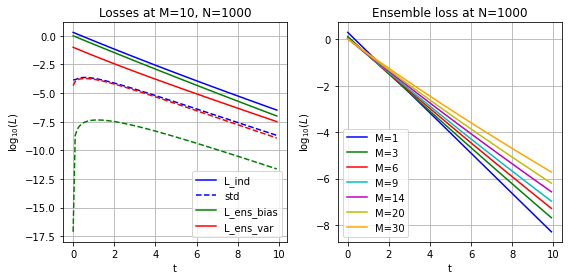

In [231]:


colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'cyan', 'slategrey', 'indigo', 'lawngreen', 'k']

fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8,4))


N_ind = 2
M_ind = 9
print(N_list[N_ind], M_list[M_ind])

tmax = 100

axes[0].plot(t_vals[:tmax], L_ind_mean[N_ind, M_ind, :tmax], color=colors[0], label='L_ind')
axes[0].plot(t_vals[:tmax], L_ind_std[N_ind, M_ind, :tmax], color=colors[0], linestyle='--', label='std')

axes[0].plot(t_vals[:tmax], L_ens_bias_mean[N_ind, M_ind, :tmax], color=colors[1], label='L_ens_bias')
axes[0].plot(t_vals[:tmax], L_ens_bias_std[N_ind, M_ind, :tmax], color=colors[1], linestyle='--')

axes[0].plot(t_vals[:tmax], L_ens_var_mean[N_ind, M_ind, :tmax], color=colors[2], label='L_ens_var')
axes[0].plot(t_vals[:tmax], L_ens_var_std[N_ind, M_ind, :tmax], color=colors[2], linestyle='--')

axes[0].legend()
axes[0].grid()
axes[0].set_xlabel('t')
axes[0].set_ylabel(r'$\log_{10}(L)$')
axes[0].set_title('Losses at M={}, N={}'.format(M_list[M_ind], N_list[N_ind]))

N_ind = 2
M_inds = [0, 2, 5, 8, 11, 14, 16]

tmax = 100

for k, M_ind in enumerate(M_inds):
    L_ens_mean = combine_log10_losses(L_ens_bias_mean[N_ind, M_ind, :tmax], L_ens_var_mean[N_ind, M_ind, :tmax])
    axes[1].plot(t_vals[:tmax], L_ens_mean, color=colors[k], label='M={}'.format(M_list[M_ind]))

axes[1].legend()
axes[1].grid()

axes[1].set_xlabel('t')
axes[1].set_ylabel(r'$\log_{10}(L)$')
axes[1].set_title('Ensemble loss at N={}'.format(N_list[N_ind]))

plt.tight_layout()
plt.show
plt.savefig('dynamic1111.pdf', dpi=300, format='pdf')

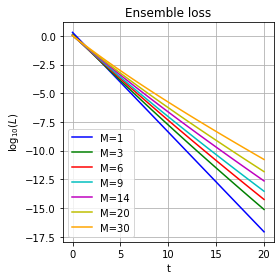

In [169]:
N_ind = 2
M_inds = [0, 2, 5, 8, 11, 14, 16]

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'cyan', 'slategrey', 'indigo', 'lawngreen', 'k']

fig, axes = plt.subplots(
    nrows=1, ncols=1,
    figsize=(4,4))

tmax = 111

for k, M_ind in enumerate(M_inds):
    L_ens_mean = combine_log10_losses(L_ens_bias_mean[N_ind, M_ind, :tmax], L_ens_var_mean[N_ind, M_ind, :tmax])
    axes.plot(t_vals[:tmax], L_ens_mean, color=colors[k], label='M={}'.format(M_list[M_ind]))

axes.legend()
axes.grid()

axes.set_xlabel('t')
axes.set_ylabel(r'$\log_{10}(L)$')
axes.set_title('Ensemble loss')

plt.show
plt.tight_layout()
plt.savefig('dynamic_M.pdf', dpi=300, format='pdf')

In [129]:
def combine_log10_losses(L_1, L_2):
    L_mean = (L_1 + L_2) / 2
    L_combined = np.exp((L_1 - L_mean)*math.log(10)) + np.exp((L_2 - L_mean)*math.log(10))
    L_combined = L_mean + np.log10(L_combined)
    
    return L_combined

[ 0.  1.  5. 50.]


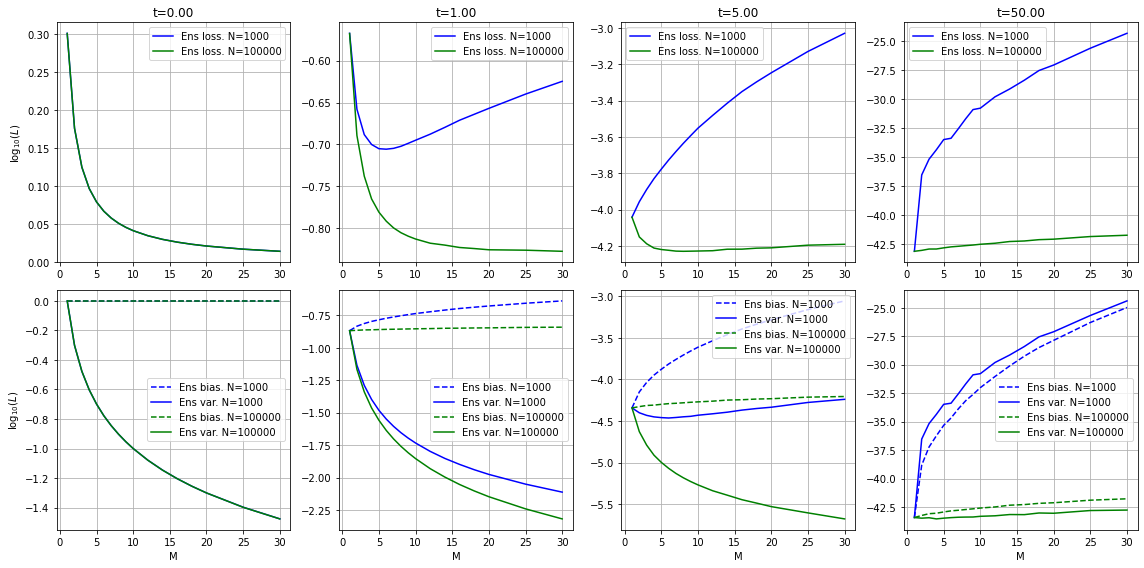

In [175]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'cyan', 'slategrey', 'indigo', 'lawngreen', 'k']

t_inds = [0, 10, 50, 140]
N_inds = [2, 6]
print(t_vals[t_inds])

fig, axes = plt.subplots(
    nrows=2, ncols=len(t_inds),
    figsize=(4*len(t_inds),8))

for j in range(len(t_inds)):
    t_ind = t_inds[j]
        
    for k, N_ind in enumerate(N_inds):
        N = N_list[N_ind]
        #axes[0][j].plot(M_list, L_ind_mean[N_ind, :, t_ind], 
        #                color=colors[k], linestyle='--', label='Ind loss. N={}'.format(N))
        L_ens_mean = combine_log10_losses(L_ens_bias_mean[N_ind, :, t_ind], L_ens_var_mean[N_ind, :, t_ind])
        #print(M_list, L_ens_mean)
        axes[0][j].plot(M_list, L_ens_mean, 
                        color=colors[k], label='Ens loss. N={}'.format(N))
            
        axes[1][j].plot(M_list, L_ens_bias_mean[N_ind, :, t_ind], 
                        color=colors[k], linestyle='--', label='Ens bias. N={}'.format(N))
        axes[1][j].plot(M_list, L_ens_var_mean[N_ind, :, t_ind], 
                        color=colors[k], label='Ens var. N={}'.format(N))

        axes[0][j].set_title('t={0:.2f}'.format(t_vals[t_ind]))
    
    axes[1][j].set_xlabel('M')
    
for i in range(2):
    axes[i][0].set_ylabel(r'$\log_{10}(L)$')
    for j in range(len(t_inds)):
        axes[i][j].legend()
        axes[i][j].grid()

plt.show
plt.tight_layout()
plt.savefig('M_dependence.pdf', dpi=300, format='pdf')

<ipython-input-221-d8bce61172ff>:3: RuntimeWarning: divide by zero encountered in true_divide
  M_opt_th = (np.array(N_list).reshape((-1,1)) / (4 * t_vals.reshape((1,-1))**2)) ** (1./3)


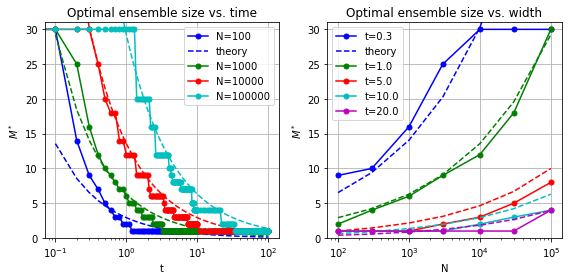

In [221]:
L_ens_mean_full = combine_log10_losses(L_ens_bias_mean, L_ens_var_mean)
M_opt = M_list[np.argmin(L_ens_mean_full, axis=1)]
M_opt_th = (np.array(N_list).reshape((-1,1)) / (4 * t_vals.reshape((1,-1))**2)) ** (1./3)
#print(M_opt)
#print(M_opt_th)


fig, axes = plt.subplots(
    nrows=1, ncols=2,
    figsize=(8,4))

N_inds = [0, 2, 4, 6]

for k, N_ind in enumerate(N_inds):
    axes[0].plot(t_vals, M_opt[N_ind, :], marker='.', markersize=10,
                 color=colors[k], label='N={}'.format(N_list[N_ind]))
    if k==0:
        axes[0].plot(t_vals, M_opt_th[N_ind, :], color=colors[k], linestyle='--', label='theory')
    else:
        axes[0].plot(t_vals, M_opt_th[N_ind, :], color=colors[k], linestyle='--')
        
t_inds = [3, 10, 50, 100, 110]        


for k, t_ind in enumerate(t_inds):
    axes[1].plot(N_list, M_opt[:, t_ind], marker='.', markersize=10, 
                 color=colors[k], label='t={0:.1f}'.format(t_vals[t_ind]))
    if k==0:
        axes[1].plot(N_list, M_opt_th[:, t_ind], color=colors[k], linestyle='--', label='theory')
    else:
        axes[1].plot(N_list, M_opt_th[:, t_ind], color=colors[k], linestyle='--')


for i in range(2):
    axes[i].grid()
    axes[i].legend()
    #axes[i].set_yscale('log')
    axes[i].set_xscale('log')
    axes[i].set_ylabel(r'$M^*$')
    
axes[0].set_xlabel('t')
axes[1].set_xlabel('N')
axes[0].set_title('Optimal ensemble size vs. time')
axes[1].set_title('Optimal ensemble size vs. width')
axes[0].set_ylim((0,31))
axes[1].set_ylim((0,31))
plt.tight_layout()
plt.show

plt.savefig('optimal_M.pdf', dpi=300, format='pdf')